# @Author:  Marktus A Atanga

# Goal:         This covers data preprocessing (data cleansing, feature generation, outlier removal and feature ranking) and data classifications using different machine learning algorithms

In [ ]:
#Imports to use in the analysis
import sys
import math
import itertools 
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
from sklearn.naive_bayes import GaussianNB
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder
sns.set()

## 1. Data cleansing: The goal of data cleansing here is to ensure points in the data with empty values are filled (missing data are filled). Data cleansing is an important first item to consider in building a machine learning model
### To do that:
#### 1. we need to generate additional data for each feature in a class and fill the empty points with this new data.
#### 2. If the number of empty data points is small (in our case, one missing data point per feature, we could entirely drop those empty points).
#### 3. We could also generate a list of data for each feature and then use that list to fill the empty spots in the data if we have more missing data.
#### 4. Since there are small missing data in our case(only one missing data point per feature per class), we want to generate one data point per feature to fill the missing data points.
#### 5. In this problem, i used pandas to read my data and because the data is identified by class and features; 
#### 5.1 I can process the data by first separating the dataframe to classes, call each class to fill the missing data for each feature

In [ ]:
#Read the data into pandas dataframe
df = pd.read_csv("C:/Users/maa5m/Desktop/2018_school/ENG685.621.81.FA19_Algorithms_for_Data_Science/" \
                 "MAtanga_Programming_HW2/inputs/iris_data_for_cleansing.csv")

In [ ]:
#Here are the statistics of the data before cleansing
print('min',df.groupby('class').min(),'\n', 'max', df.groupby('class').max(), '\n',
     'mean', df.groupby('class').mean(), '\n','std', df.groupby('class').std() )

In [ ]:
def data_cleansing(df):    
    """
    This function accepts a dataframe. it identifies data by class type
    Then, it generates a point for each feature in a class, that data point fills NaN in the feature
    Notice that only one data point is generated and the value is bounded by the min/max values of 
    the feature. This would not be a good idea if more data are missing in a feature because that would skew the
    statistics of the feature in the direction of the new data point.
    If more data points are missing, then it would be preferrable to generate a list of data points to fill in
    """
    np.seterr(divide='ignore', invalid='ignore') #skip NaN in the data
    
    storage = pd.DataFrame()    
    for claz in df['class'].unique():   #identify unique classes in the data
        data = df[df['class']==claz]
        mins = data.min()
        maxs = data.max()
        mean = data.mean()
        std = data.std()
        
        for feature in data.columns:   
            
            if (feature =='class'):
                continue         
            #one data point to fill NaN  
            new_data = np.random.uniform(mins[feature], maxs[feature], size=1)#*std[feature]
             
            new = (((new_data-mins[feature])/(maxs[feature]-mins[feature]))*
                   (maxs[feature]-mins[feature]) + mins[feature])                       
            
            data[feature] =  data[feature].fillna(float(new)) #fill NaN with the new data point
        storage = storage.append(data)
    return storage


df_new = data_cleansing(df)

#df_new.to_csv("C:/Users/maa5m/Desktop/2018_school/ENG685.621.81.FA19_Algorithms_for_Data_Science/" \
                 #"MAtanga_Programming_HW2/outputs/iris_data_cleaned.csv", index=None)

#check if the statistics of updated data have changed
print('min',df_new.groupby('class').min(),'\n\n', 'max', df_new.groupby('class').max(), '\n\n',
     'mean', df_new.groupby('class').mean(), '\n\n','std', df_new.groupby('class').std() )

# 2. Generate two sets of features from the original 4 features to end up with a total of 8 featres
### The goal of feature generation is not to increase the number of data points of a feature but to get an entirely new feature from the known features that might give us better class separability. 
### To cheive this, we select the two top ranking features: these are existing features that show strong strong class separability (large between class means difference and small within class variation). For smaller data set such as the Iris data set, we could easily see this by plotting the data.
### Also, from the statistics of the data, a good choice is to use sepal length and petal width (large between class mean difference and smaller withing class variation) . From the plots, one could choose petal width versus petal length or petal width versus sepal width.

In [ ]:
#input data is the result from data cleaning
df2= pd.read_csv("C:/Users/maa5m/Desktop/2018_school/ENG685.621.81.FA19_Algorithms_for_Data_Science/" \
                 "MAtanga_Programming_HW2/outputs/iris_data_cleaned_final1.csv")

#statistics of the features
print('Statistics of the features')
print(df2.describe())

print('\n correlation of features in the data to select two from the ofiginal features that give better class sparation')
print('From these, it is clear that sepal length and petal width would give us better class separation\n')

sns.pairplot(df2, hue="class", diag_kind='hist')

In [ ]:
def featureGen(df): 
    """
    1. The featureGen function takes the Iris data and only select the two highly ranked features; 
    sepal length and petal width. 
    2. Sort the data by class to ensure that we can identify data class by index
    3. it generates uniformly distributed random data between 0 and 1
    4. We multiply the generated data by the covariance of the class features
    5. Finally we normalize the data using min/max of each class features - min-max normalization
    """
    np.seterr(divide='ignore', invalid='ignore') #skip NaN in the data
    
    #sort base on class identifier, this will help us map our new data to this data easily
    df =df.sort_values(by=(['class'])) 
    
    sample_df = df[['sepal length', 'petal width', 'class']] #select the most important two features
    
    for claz in sample_df['class'].unique():   #iterate over classes
        data = sample_df[sample_df['class']==claz]
    
        temp = data.drop(['class'], axis=1) ##use this to avoid class lable in stats calculations 
    
        mins = temp.min() #min values of class features
        mins = np.transpose(np.array(mins.values))
    
        maxs = temp.max() #max values of class features
        maxs = np.transpose(np.array(maxs.values))
    
        covmatrix = temp.cov() #covariance of class features
        covmatrix = np.array(covmatrix)
    
        temp = np.transpose(np.array(temp.values))
        
        rnd_data = np.array(np.random.uniform(0, 1, size=(50, 2))) #generate random data
        
        rnd_data = rnd_data.dot(covmatrix) #multiply by covariance of the features
               
        if claz==1:
            rnd_data_norm_temp_1 = np.empty([50, 2]) #use to temporally store iteration for each class
            for i in range(0,2):
            
                rnd_data_norm_temp_1[:,i] = (((rnd_data[:,i]-min(rnd_data[:,i]))/(max(rnd_data[:,i])-min(rnd_data[:,i])))*
                                          (maxs[i]-mins[i]) + mins[i])          
            rnd_data_norm_temp_1 = pd.DataFrame(rnd_data_norm_temp_1)
            rnd_data_norm_temp_1.columns=['New Feature 3', 'New Feature 4']
            rnd_data_norm_temp_1['class'] = claz
    
        if claz==2:
            rnd_data_norm_temp_2 = np.empty([50, 2])
            for i in range(0,2):        
                rnd_data_norm_temp_2[:,i] = (((rnd_data[:,i]-min(rnd_data[:,i]))/(max(rnd_data[:,i])-min(rnd_data[:,i])))*
                                          (maxs[i]-mins[i]) + mins[i])          
            rnd_data_norm_temp_2 = pd.DataFrame(rnd_data_norm_temp_2)
            rnd_data_norm_temp_2.columns=['New Feature 3', 'New Feature 4']
            rnd_data_norm_temp_2['class'] = claz
            
        if claz==3: 
            rnd_data_norm_temp_3 = np.empty([50, 2])
            for i in range(0,2):        
                rnd_data_norm_temp_3[:,i] = (((rnd_data[:,i]-min(rnd_data[:,i]))/(max(rnd_data[:,i])-min(rnd_data[:,i])))*
                                          (maxs[i]-mins[i]) + mins[i])       
            rnd_data_norm_temp_3 = pd.DataFrame(rnd_data_norm_temp_3)
            rnd_data_norm_temp_3.columns=['New Feature 3', 'New Feature 4']
            rnd_data_norm_temp_3['class'] = claz
                    
    
    farmes = [rnd_data_norm_temp_1, rnd_data_norm_temp_2, rnd_data_norm_temp_3]    
    rnd_data_norm = pd.concat(farmes)
   
    rnd_data_norm = rnd_data_norm.reset_index(drop=True) #reset index after concatenation 
    rnd_data_norm['merger'] = rnd_data_norm.index #use merger to merge new features to original dataframe
    
    df = df.reset_index(drop=True)
    df['merger'] = df.index #original dataframe
        
    results = pd.merge(df, rnd_data_norm, on='merger') #merge new features to existing features
    
    return results


#new features
rnd_data_norm = featureGen(df2)

#save data to csv
rnd_data_norm.to_csv("C:/Users/maa5m/Desktop/2018_school/ENG685.621.81.FA19_Algorithms_for_Data_Science/" \
                 "MAtanga_Programming_HW2/outputs/iris_data_newFeatures.csv", index=None)

#take a peak at the new features
rnd_data_norm.head()

# 3. Perform Feature Preprocessing: Use an outlier removal method to remove any outliers. 
### Goal: the reason for outlier removal is to prevent outliers from skewing the analysis of the data. 
### Approach 1: Outlier removal can be done by defining a threshold such as the Mahalanobis distance and remove any data points outside of this distance. The Mahalanobis distance works for data that is normally distributed. So to this this criteria, we would want to test for normal distribution using normal distribution test such as the Chi-square test.
### Approach 2: Another approach is to add the standard deviation of the data to the mean of the data which we can then use as the Mahalanobis distance/threshold. Any data point outside that can be considered an outlier. 
### Approach 3: Define threhold by multiplying the mean of the data by a factor k, base on the level of scatter in the data. And value greater than mean*k is an outlier.
### For the sake of simplicity, we shall use the second approach (sum(mean, std) = threshold. We could als visualized the data and select threshold base on the outliers we see from the plots.

In [ ]:
def removeOutliers(df, extreme=False, verbose=False):
    """
    This function determines the threshold based on the mean and standard deviation of the 
    feature and removes data greater than that threshold. If there were extreme outliers, we could 
    just multiply the mean by a factor.
    """
    
    k = 3. if extreme else 1.1    
    threshold = np.mean(df) * k #approach 3    
    threshold2 = np.mean(df) + np.std(df, ddof=1) #approach 2

    outliers = []
    filt_data = []
    
    for i in range(len(df)):
        if df[i] > threshold2:            
            outliers.append(df[i])  # index of the outlier is i, append the outlier
    filt_data = [x for x in df if x not in outliers] #remove the outliers from the data

    return filt_data

In [ ]:
"""
Now let's take our 8 features data and remove outliers from them We split the data into classes and for each 
class, we will send in each feature to the outlier removal function. The removeOutliers() function determines
the threshold based on the mean and standard deviation of the feature and removes outliers
"""
input_df3= pd.read_csv("C:/Users/maa5m/Desktop/2018_school/ENG685.621.81.FA19_Algorithms_for_Data_Science/" \
                 "MAtanga_Programming_HW2/outputs/iris_data_newFeatures_final2.csv")

input_df3 = input_df3.drop(['class_x', 'merger'], axis=1)
input_df3 = input_df3.rename(columns={"class_y": "class"})

for claz in input_df3['class'].unique():
    data = input_df3[input_df3['class']==claz]
    if claz==1:
        #check1, check2 = removeOutliers(data, extreme=False)
        setosa = data.apply(lambda col: pd.Series(removeOutliers(list(col), extreme=False)), axis=0)
        seto = setosa.dropna() #remove all rows where outliers where removed
        seto.reset_index(drop=True)
    elif claz==2:
        versicolor = data.apply(lambda col: pd.Series(removeOutliers(list(col), extreme=False)), axis=0)
        versi= versicolor.dropna()
        versi.reset_index(drop=True)
    else:
        virginica = data.apply(lambda col: pd.Series(removeOutliers(list(col), extreme=False)), axis=0)
        virg = virginica.dropna()
        virg.reset_index(drop=True)

filt_data = pd.concat([seto, versi, virg]) #final data from outlier removal

filt_data.to_csv("C:/Users/maa5m/Desktop/2018_school/ENG685.621.81.FA19_Algorithms_for_Data_Science/" \
                 "MAtanga_Programming_HW2/outputs/iris_data_outlier_removed.csv" , index=None)

In [ ]:
print('Let us visualize the data before we removed outliers')
sns.pairplot(input_df3, hue="class", diag_kind='hist')

seto1 = input_df3[input_df3['class']==1]
versi1 = input_df3[input_df3['class']==2]
virg1 = input_df3[input_df3['class']==3]

print('setso=', seto1.describe(), '\n\n','versicolor=', versi1.describe(), '\n\n','virginca= ', virg1.describe())

In [ ]:
print('let us visualize the data after outliers are removed')
print("We can observe that after the outliers are removed, there is clearer separation between")
print("New feature 2 versus sepal width or sepal length, and New feature 2 versus New feature 4")

sns.pairplot(filt_data, hue="class", diag_kind='hist')


print('Some changes are observed in the statistics of the data such as max, mean, standard deviation\n')

print('setso=\n', seto.describe(), '\n\n','versicolor=\n', versi.describe(), '\n\n','virginca= \n', virg.describe())

# 4. Feature ranking; 
### Feature selection is part of the core concepts in machine learning which greatly impact the machine learning model (MLM) performance. This is beacuse the data used to train the machine learning model have influence on the model performance/accuracy. Feature selection and data cleansing are the very first things one should consider in designing a MLM
### The goal of feature ranking is to get rid of features that do not give good class sparability so that the model is not exposed to learn from irrelevant features. Ideally, we want to use featues with large between class means and smaller within class variation.
### By selecting only relevant features:
###    1. Reduce/avoid overfitting
###    2. Improve model accuracy 
###    3. Reduce training time

In [ ]:
class dataHolder:
    X = np.zeros((8,114))
    Y = [((1,3))]

class FisherModel:
    featureIndex = [];
    rankValue = [];
    featureRankingMethod = '';
    Pclass = [];
    Prior = []

In [ ]:
def fishersMultiClassFeatureRanking(data,method,featureCount):
    X = data.X;
    Y = data.Y;
    #print(featureCount)
    #print("X=", X, '\n', 'Y=', Y)
    [numEx, vDim] = X.shape;

    oDim = np.max(Y);
    #alg.rank = [];

    Wtmp= np.zeros((3,featureCount))
    if (oDim>=2):
        Std = np.zeros((1, vDim),dtype=int);
        for i in range(1,oDim+1): # classes 1,2 &3   condition is 1 < i < 4
            indQ = [index for index in range(len(Y)) if Y[index]==i]
            Std = Std + np.round(np.std(X[indQ,:],axis=0),featureCount);

        for i in range(0, oDim):
            indp = [index for index in range(len(Y)) if Y[index] == i+1]
            Wtmp[i] = np.round((np.mean(X[indp, :], axis=0) / Std),featureCount)

        Wtmp = np.transpose(Wtmp)
        indTemp = [];
        corrTemp = [];
        WW = []
        for j in range(oDim):
            # WW = [Wtmp[:, 1: j - 1], Wtmp[:, j : oDim]];
            # WW = (Wtmp[:, j] * np.ones((1, oDim - 1)) - WW);
            if  j == 0 :
                WW = np.transpose([Wtmp[:, 1], Wtmp[:, 2]]);
            if  j == 1 :
                WW = np.transpose([Wtmp[:, 0], Wtmp[:, 2]]);
            if  j == 2 :
                WW = np.transpose([Wtmp[:, 0], Wtmp[:, 1]]);

            WW = np.round(np.transpose(np.array([Wtmp[:, j]]) * np.ones((oDim - 1, 1))) - WW,featureCount);

            if method == 1:
                rankW = np.min(WW,axis=1);
            elif method == 2:
                rankW = np.max(WW,axis=1);
            elif method == 3:
                rankW =np.transpose(np.sum(np.transpose(WW)));
            elif method == 4:
                r1 = min(WW, [], 2);
                r2 = max(WW, [], 2);
                rankW = (r1 + r2) / 2;

            rankW = -abs(np.transpose(rankW))
            v = np.argsort(rankW);
            u = np.zeros(len(v))
            for i in range(0, len(v)):
                u[i] = rankW[v[i]]
            indTemp.append(np.transpose(v));
            corrTemp.append(np.transpose(u));

        indTemp = np.transpose(indTemp)
        indTemp = np.reshape(indTemp, (1, oDim * vDim))[0]
        corrTemp = np.reshape(np.transpose(corrTemp), (1, oDim * vDim))[0]


        indx = np.argsort(corrTemp);
        corrSort = np.zeros(np.size(indx))

        for i in range(0, len(indx)):
            corrSort[i] = corrTemp[indx[i]]
        indx = (indx + np.ones((1, indx.size), dtype=int))

        indxSort = indTemp#indTemp(indx);
        indTemp = np.fliplr([indxSort]);
        corrTemp = np.fliplr([corrSort]);

        u = np.unique(indTemp);
        for i in range(0, len(u)):
            v[i] = np.where(indTemp[0] == u[i])[0][0] + 1

        s = np.argsort(v)
        w = np.zeros(np.size(s),dtype=int)

        for i in range(0, len(s)):
            w[i] = v[s[i]]

        values = []
        for i in w:
            values.append(corrTemp[0][i])
        values = np.fliplr([values]);

        values1 = []
        for i in s:
            values1.append(u[i])

        rankIndx = np.fliplr([values1]);

        model = FisherModel()
        model.featureIndex = rankIndx[0]
        model.rankValue = values[0];
        model.featureRankingMethod = 'fishersMultiClassFeatureRanking';

        return model

In [ ]:
df4 = pd.read_csv("C:/Users/maa5m/Desktop/2018_school/ENG685.621.81.FA19_Algorithms_for_Data_Science/" \
                 "MAtanga_Programming_HW2/outputs/iris_data_outlier_removed_final2.csv")

#weka_data = pd.read_csv('updated_iris.csv')
#X = np.zeros((8,150))
#Y = [((1,3))]
#df4 = df4.drop(['class'], axis=1)


X = [df4['sepal length'].values, df4['sepal width'].values,
    df4['petal length'].values, df4['petal width'].values,
    df4['New Feature 1'].values, df4['New Feature 2'].values,
    df4['New Feature 3'].values, df4['New Feature 4'].values];

y = []
for i in range(1,4): #3 classes 1, 2, 3 exluding 4 th loop
    for j in range(38):
        y.append(1*i)
y = np.array(y)

#print(len(weka_data.columns)-1)
data = dataHolder()
data.X = np.transpose(X)
data.Y = np.transpose(y)

model =  fishersMultiClassFeatureRanking(data,1,(len(df4.columns)-1))

print(df4.head(), '\n')

print('model ranks petal width and New feature 3 as the top 2 features. Will use these features for classification')
print('However, looking at the plots in 3 above after outliers removal, new feature 2 has better better separation')
print('with other features,especially with new feature 4. Also, new feature 2 and petal width has last between class'
      'mean difference','\n\n')


print('Raking=', model.featureIndex)



### 5. Reduce the dimensionality to two features using PCA or Kernel PCA
#### Since PCA yields a feature subspace that maximizes the variance along the axes, we would standardize the data. This is very especially if the data were measured on different scales. Transformation of data to unit scale (mean=0 and variance=1) helps with optimal performance of many machine learning algorithms.
#### In this instance i used python built in PCA for the analysis and if time permits, i would design PCA from scratch to have better understanding of it's working nitty gritties.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#let's use our clean data from outlier removal
df5 = pd.read_csv("C:/Users/maa5m/Desktop/2018_school/ENG685.621.81.FA19_Algorithms_for_Data_Science/" \
                 "MAtanga_Programming_HW2/outputs/iris_data_outlier_removed_final2.csv")

features = ['sepal length', 'sepal width', 'petal length', 'petal width', 'New Feature 1','New Feature 2']
x = df5.loc[:, features].values
y = df5.loc[:,['class']].values

x = StandardScaler().fit_transform(x) #standardize the data

#Using built-in python PCA 
pca = PCA(n_components=2)
PCs = pca.fit_transform(x)
PC_df = pd.DataFrame(data = PCs, columns = ['PCA1', 'PCA2'])
final_df = pd.concat([PC_df, df5[['class']]], axis = 1)

# plot the data with PCA1, PCA2 as the new dimension
np_data = np.array(final_df)
class_id = np_data[:,2] #class column of data
label_dict = {1: 'setosa', 2: 'versicolor', 3:'Virginica'} #class label dictionary

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 

for label,marker,color in zip(range(1,4),('X', '<', 'o'),('orange', 'purple', 'green')):     
    plt.scatter(x=np_data[:,0].real[class_id == label], 
                y=np_data[:,1].real[class_id == label],
            marker=marker,color=color,alpha=0.5, label=label_dict[label]
            )
    
plt.xlabel('PCA-1', fontsize = 15)
plt.ylabel('PCA-2', fontsize = 15)
plt.title('2 Component PCA', fontsize = 20)
plt.legend(bbox_to_anchor=(1, 1))

plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

# 6. Using the following Machine Learning techniques, classify the three class Iris data:

### 6a. Expectation Maximization

## 6b. Either Fisher Linear Discriminant (Linear Discriminant Analysis), Kernel Fisher's Discriminant or Parzen Window. I have chosen the Linear Discriminant Analysis (LDA) for the classification.
### The idea of LDA is to find a new feature space to project the data in order to maximize classes separability. Fisher’s proposal of LDA is basically to maximize the distance between class to class varince/means and minimize the spreading within the class itself. So we have two things to be concerned about here; the within-class variation and the between-class variation. The limitation to LDA is that as the name suggest, it works well for data that are linearly separable. Aside that, it is formulated for data that follow Normal Distribution. So it might not be that useful for non-Gaussian data without modification.

In [ ]:
#Let's use the data after outliers are removed
df_new = pd.read_csv("C:/Users/maa5m/Desktop/2018_school/ENG685.621.81.FA19_Algorithms_for_Data_Science/" \
                 "MAtanga_Programming_HW2/outputs/iris_data_outlier_removed_final1.csv")

data = df_new[['sepal length','sepal width','petal length','petal width', 'New Feature 1','New Feature 2']].values
class_id = df_new['class'].values
label_dict = {1: 'setosa', 2: 'versicolor', 3:'Virginica'} #class label dictionar

dm = data.shape[1] #dimension of data

"""
compute the mean vector for the 3 classes
"""
mean_vectors = []
for claz in range(1,4):
    mean_vectors.append(np.mean(data[class_id==claz], axis=0))

"""
calculate overall mean features for the 3 classes
"""
overall_mean = np.mean(data, axis=0)



"""
calculate the within class scatter matrix (SW)
"""
K = data.shape[0]*data.shape[1] # total number data points for all classes
S_W = np.zeros((dm,dm))
for claz,mean_cvector in zip(range(1,4), mean_vectors):
    class_sct_mat = np.zeros((dm,dm))                      # scatter matrix for every class
    for row in data[class_id == claz]:
        row, mean_cvector = row.reshape(dm,1), mean_cvector.reshape(dm,1)      # make column vectors
        Kc = data[class_id==claz].shape[0]*data[class_id==claz].shape[1] 
        class_sct_mat += (Kc/K)*((row-mean_cvector).dot((row-mean_cvector).T))
    S_W += class_sct_mat 
    

"""
Calculate the between class scatter matrix (SB)
"""
S_B = np.zeros((dm,dm))
for i,mean_vec in enumerate(mean_vectors):  
    mean_vec = mean_vec.reshape(dm,1) # column vectors
    overall_mean = overall_mean.reshape(dm,1) # column vectors
    S_B += (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
    
"""
Solve the generalized eigen value probelm to get the discriminant (eigen vector, eigen value pair)
"""
eigvals, eigvecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
for i in range(len(eigvals)):
    eigvec_sc = eigvecs[:,i].reshape(dm,1)  
eigpairs = [(np.abs(eigvals[i]), eigvecs[:,i]) for i in range(len(eigvals))]

"""
The eigen vectors with the largest eigen values have the most variance and most 
information about the data and hence better feature separation
Sort the eigen values and select the largest
"""
eigpairs = sorted(eigpairs, key=lambda k: k[0], reverse=True)

"""
We can use a reduction matrix of k eigen vectors for the top k eigen values to transform the 
the data from n-dimentional feature space to k-dimentional feature space.
"""
W_1d = np.hstack((eigpairs[0][1].reshape(dm,1))) #1d projection
W_2d = np.hstack((eigpairs[0][1].reshape(dm,1), eigpairs[1][1].reshape(dm,1))) #2d projection
W_3d = np.hstack((eigpairs[0][1].reshape(dm,1), eigpairs[1][1].reshape(dm,1),eigpairs[2][1].reshape(dm,1)))


#Determine a threshold that we can use to tell which class an observation belong
nd = 2 #number of projection dimensions
w = np.array([eigpairs[i][1] for i in range(nd)])

total = 0
for c in range(1,nd):
    total += np.dot(w, mean_vectors[c])
b = -0.5 * total

#Two class classification
claz1 = mean_vectors[0]
claz2 = mean_vectors[1]
y1 = np.dot(w, mean_vectors[0])
y2 = np.dot(w, mean_vectors[1])
if (y1+b>=0).any():
    claz_1 = '1'
else:
    claz_1 = '-1'
if (y2+b>=0).any():
    claz_2 = '1'
else:
    claz_2 = '-1'

#three class classification
y1 = np.dot(w, mean_vectors[0])
y2 = np.dot(w, mean_vectors[1])
y3 = np.dot(w, mean_vectors[2])
if (y1+b>=0).any():
    claz_1 = '1'
else:
    claz_1 = '-1'
if (y2+b>=0).any():
    claz_2 = '1'
else:
    claz_2 = '-1'
if (y3+b>=0).any():
    claz_3 = '1'
else:
    claz_3 = '-1'
print(claz_1, claz_2, claz_3)

#project the samples into a new sample space using the W
data_1d = data.dot(W_1d)
data_2d = data.dot(W_2d)
data_3d = data.dot(W_3d)

#plot the projected data
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

#if data is projected to 1d
for label,marker,color in zip(range(1,4),('X', '<', 'o'),('orange', 'purple', 'green')):     
    ax1.plot(data_1d.real[class_id == label],
            marker=marker,color=color,alpha=0.5, label=label_dict[label]
            )

#if data is porjected to 2d
for label,marker,color in zip(range(1,4),('X', '<', 'o'),('orange', 'purple', 'green')):     
    ax2.scatter(x=data_2d[:,0].real[class_id == label], 
                y=data_2d[:,1].real[class_id == label],
            marker=marker,color=color,alpha=0.5, label=label_dict[label]
            )

ax1.set_title('LDA Analysis of Iris data: projection to 1 linear discriminant', fontsize=14)
ax1.grid(which='major', linestyle='-', linewidth='0.5', color='black')
ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax1.legend(bbox_to_anchor=(0.5, 0.5))
ax1.set_xlabel('index', fontsize=14)
ax1.set_ylabel('LDA', fontsize=14)
ax1.set_axisbelow(True)
ax1.minorticks_on()

ax2.set_title('LDA Analysis of Iris data: projection to 2 linear discriminants', fontsize=14)
ax2.grid(which='major', linestyle='-', linewidth='0.5', color='black')
ax2.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax2.legend(bbox_to_anchor=(0.8, 1))
ax2.set_xlabel('LDA1', fontsize=14)
ax2.set_ylabel('LDA2', fontsize=14)
ax2.set_axisbelow(True)
ax2.minorticks_on()


# 6c. Neural network for Iris data classification

### A neural network is a supervised learning algorithm in which we provide it some input data containing the independent variables and the output data that contains the dependent variable. Here, plant features are the independent variables and the plant class is the dependent variable. The neural network makes some random predictions and the predictions are matched with the correct output. The difference between the predicted values and the actual values call the error or cost is calculated. The function for finding the cost is called the cost function and minimizing this cost function is the objective of a neural network. Therefore, by  training a neural network, we seek to minimize this cost function. 
## Steps: Two main steps involved are Feed Forward and Back Propagation
###   Feed Forward steps:
####  1. First we calculate teh sum of the product of the input and their weigts, plus a bias term. This can be implemented using dot product. 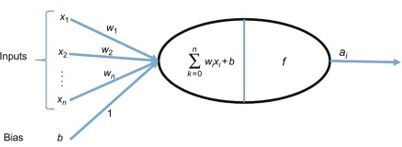                                                                                                                           
####  2. The results from step 1 may not be a discrete number (0 or 1), so we will pass the results through an activation function. Several of such functions exist but i chose the sigmoid function for this case: 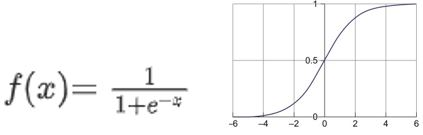 - if the input to the activation function is a postive large number, we get 1 as output, if the input to the activation function is zero, we get 0.5 as an output and if the input to the activation function is negative, we get 0 as ouput. 
### Back Propagation steps:
#### The back propagation step is where the actual training of the neural network occur. The results of the feed forward step is just the neural net taking a guess of what the outputs are given a set of inputs. This prediction could be far off from the actual and so we need to help the neural network to make better prediction to get much closer to the actual outputs. This is done by fine tunning the weights and the bias term. This process of fine tunning the weights and the bias term is call back propagation and it is where the actual training of the neural network occur.
#### 1. First calculate the cost/error of the prediction - the difference between the predicted output and the actual output. A good cost function to calculate the cost is the mean square error function (MSE). 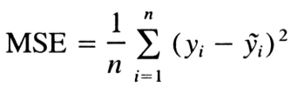, where y is the actual output, y-bar is the predicted output and n is the number of observations.
#### 2. Next is to minimize the cost function - the altimate goal of the neural network. Since we can not control the inputs or the sigmoid function or the dot product, the only means of minimizing the cost function is to control the weight and/or the bias term. This generally becomes an optimization function where we have to find the minimum of the function. Several optimization algorithms exist but I will use the gradient descent algorithm.
#### Generally, finding the minimum or maximum of a function involve basic calculus where we take the derivative of the cost function at a given point (gradient/slope of the function at that point). if the derivative is negative, then the function is maximum which signal increasing cost and if it is positive, then the function is minimum whihc signal decreasing cost.

## References:
### 1. https://www.sciencedirect.com/topics/computer-science/sigmoid-function
### 2. https://towardsdatascience.com/how-does-back-propagation-in-artificial-neural-networks-work-c7cad873ea7
### http://scs.ryerson.ca/~aharley/neural-networks/
### http://cs231n.github.io/neural-networks-case-study/

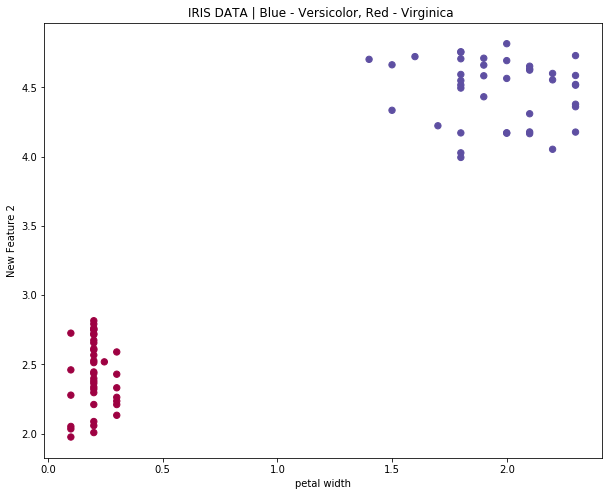

In [25]:
#https://towardsdatascience.com/neural-network-on-iris-data-4e99601a42c8
#import libraries
import os
import pandas as pd

#Let's use the data after outliers are removed
iris = pd.read_csv("C:/Users/maa5m/Desktop/2018_school/ENG685.621.81.FA19_Algorithms_for_Data_Science/" \
                 "MAtanga_Programming_HW2/outputs/iris_data_outlier_removed_final2.csv")

iris = iris[iris['class']!=2]

#Create Input and Output columns
X = iris[['petal width', 'New Feature 2']].values.T
Y = iris[['class']].values.T
Y = Y.astype('uint8')
#Make a scatter plot
plt.scatter(X[0, :], X[1, :], c=Y[0,:], s=40, cmap=plt.cm.Spectral);
plt.title("IRIS DATA | Blue - Versicolor, Red - Virginica ")
plt.xlabel('petal width')
plt.ylabel('New Feature 2')
plt.show()


def initialize_parameters(n_x, n_h, n_y):
    
    np.random.seed(2) # we set up a seed so that our output matches ours although the initialization is random.
    
    W1 = np.random.randn(n_h, n_x) * 0.01 #weight matrix of shape (n_h, n_x)
    b1 = np.zeros(shape=(n_h, 1))  #bias vector of shape (n_h, 1)
    W2 = np.random.randn(n_y, n_h) * 0.01   #weight matrix of shape (n_y, n_h)
    b2 = np.zeros(shape=(n_y, 1))  #bias vector of shape (n_y, 1)
    
    print('W1=', W1, '\n', 'W2=', W2, '\n', 'b1=', b1, '\n', 'b2=', b2)
    #store parameters into a dictionary    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}    
    return parameters

#Function to define the size of the layer
def layer_sizes(X, Y):
    n_x = X.shape[0] # size of input layer
    n_h = 6# size of hidden layer
    n_y = Y.shape[0] # size of output layer
    return (n_x, n_h, n_y)

def forward_propagation(X, parameters):
#retrieve intialized parameters from dictionary    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']    
    
    # Implement Forward Propagation to calculate A2 (probability)
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)  #tanh activation function
    Z2 = np.dot(W2, A1) + b2
    A2 = 1/(1+np.exp(-Z2))  #sigmoid activation function
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

def compute_cost(A2, Y, parameters):
   
    m = Y.shape[1] # number of training examples
    
    # Retrieve W1 and W2 from parameters
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # Compute the cross-entropy cost
    logprobs = np.multiply(np.log(A2), Y) + np.multiply((1 - Y), np.log(1 - A2))
    cost = - np.sum(logprobs) / m
    print('m=', m, '\n', 'A2=', A2, '\n', 'logprobs=', logprobs)
    
    return cost

def backward_propagation(parameters, cache, X, Y):
# Number of training examples
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    W1 = parameters['W1']
    W2 = parameters['W2']
    ### END CODE HERE ###
        
    # Retrieve A1 and A2 from dictionary "cache".
    A1 = cache['A1']
    A2 = cache['A2']
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    dZ2= A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

def update_parameters(parameters, grads, learning_rate=1.2):
# Retrieve each parameter from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # Retrieve each gradient from the dictionary "grads"
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    
    # Update rule for each parameter
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

def nn_model(X, Y, n_h, num_iterations=10000, print_cost=False):
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
         
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2, Y, parameters)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads)
        
        ### END CODE HERE ###
        
        # Print the cost every 1000 iterations
        if print_cost and i % 5 == 0:
            print("Cost after iteration %i: %f" % (i, cost))
    return parameters,n_h


In [26]:
parameters = nn_model(X,Y , n_h = 6, num_iterations=200, print_cost=True)

W1= [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]
 [-0.01057952 -0.00909008]
 [ 0.00551454  0.02292208]] 
 W2= [[ 0.00041539 -0.01117925  0.00539058 -0.0059616  -0.0001913   0.01175001]] 
 b1= [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]] 
 b2= [[0.]]
m= 80 
 A2= [[0.50008868 0.50008591 0.5000847  0.50008444 0.50006864 0.50008353
  0.50008898 0.50006353 0.50007749 0.50008399 0.50006719 0.50007523
  0.50007747 0.50008869 0.50008097 0.50007626 0.50007671 0.5000785
  0.5000822  0.50008645 0.50008179 0.50006405 0.50008784 0.50007985
  0.50007305 0.50008763 0.50009053 0.5000782  0.50008985 0.50006183
  0.50007953 0.50007795 0.50007553 0.50007059 0.50008336 0.50007898
  0.50008844 0.5000838  0.5000695  0.50007586 0.50019744 0.50020073
  0.50021438 0.50020893 0.50019502 0.50020682 0.50021316 0.50020922
  0.5002319  0.50021973 0.50022802 0.50021653 0.50021723 0.50021833
  0.50023205 0.50022751 0.50021615 0.50022366 0.500212   0.50021075
  0.

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in multiply


 
 logprobs= [[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan -inf -inf
  -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]]
m= 80 
 A2= [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1.]] 
 logprobs= [[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan -inf -inf
  -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf -inf

  1. 1. 1. 1. 1. 1. 1. 1.]] 
 logprobs= [[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan -inf -inf
  -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]]
m= 80 
 A2= [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1.]] 
 logprobs= [[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan -inf -inf
  -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf

  1. 1. 1. 1. 1. 1. 1. 1.]] 
 logprobs= [[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan -inf -inf
  -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]]
Cost after iteration 115: nan
m= 80 
 A2= [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1.]] 
 logprobs= [[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan -inf -inf
  -inf -inf -inf -inf -inf

  1. 1. 1. 1. 1. 1. 1. 1.]] 
 logprobs= [[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan -inf -inf
  -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]]
m= 80 
 A2= [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1.]] 
 logprobs= [[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan -inf -inf
  -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf

In [39]:
import pandas as pd

iris = pd.read_csv("C:/Users/maa5m/Desktop/2018_school/ENG685.621.81.FA19_Algorithms_for_Data_Science/" \
                 "MAtanga_Programming_HW2/outputs/iris_data_outlier_removed_final2.csv")

#iris = iris[iris['class']!=2]

#Create Input and Output columns
X = iris[['petal width', 'New Feature 2']].values
Y = iris[['class']].values
Y = Y.astype('uint8')

np.unique(y)

array([1, 2, 3], dtype=uint8)

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [41]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
mlp.fit(X_train, y_train)

c:\program files\python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 10, 10), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [42]:
predictions = mlp.predict(X_test)

In [43]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test,predictions))

print(classification_report(y_test,predictions))

[[ 6  0  0]
 [ 0  6  0]
 [ 0  0 12]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00        12

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



In [94]:
class Perceptron(object):
    def __init__(self, rate = 0.01, niter = 10):
            self.rate = rate
            self.niter = niter

    def fit(self, X, y):
        """
        Fit training data
        """
        # weights
        self.weight = np.zeros(1 + X.shape[1])

        # incorrect of misclassifications
        self.errors = []  

        for i in range(self.niter):
            err = 0
            for xi, target in zip(X, y):
                delta_w = self.rate * (target - self.predict(xi))
                self.weight[1:] += delta_w * xi
                self.weight[0] += delta_w
                err += int(delta_w != 0.0)
                self.errors.append(err)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.weight[1:]) + self.weight[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

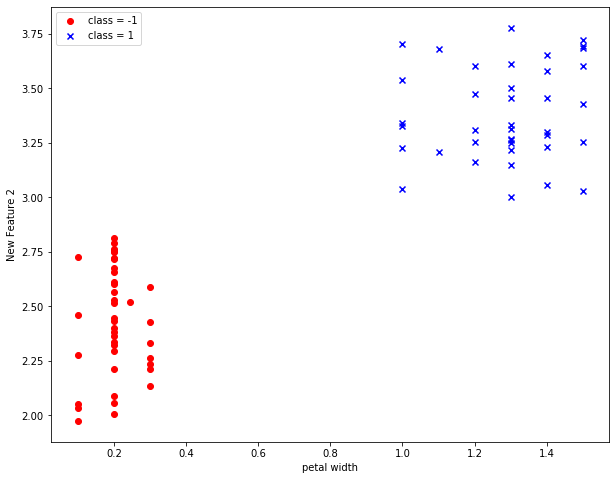

In [95]:
df6c = pd.read_csv("C:/Users/maa5m/Desktop/2018_school/ENG685.621.81.FA19_Algorithms_for_Data_Science/" \
                 "MAtanga_Programming_HW2/outputs/iris_data_outlier_removed_final2.csv")

df6c = df6c[df6c['class']!=3]

#Create Input and Output columns
X = df6c[['petal width', 'New Feature 2']].values
target = df6c['class']

Y = []
for claz in target:
    if(claz == 1):
        Y.append(-1)
    else:
        Y.append(1)
           
plt.scatter(X[:40, 0], X[:40, 1], color='red', marker='o', label='class = -1')
plt.scatter(X[41:80, 0], X[41:80, 1], color='blue', marker='x', label='class = 1')
plt.xlabel('petal width')
plt.ylabel('New Feature 2')
plt.legend(loc='upper left')
plt.show()

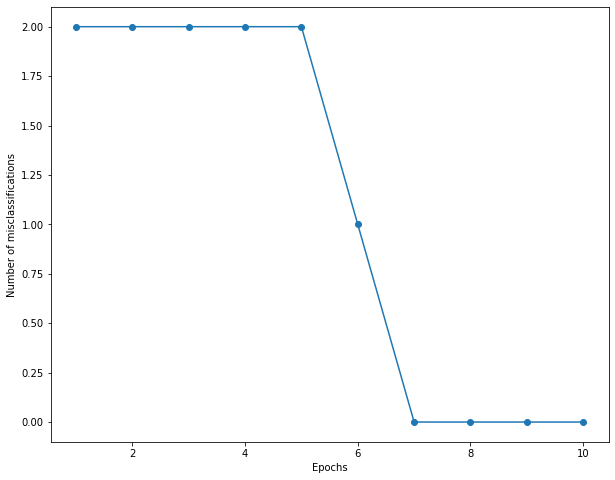

In [98]:
# import Perceptron calss from NeuralNet.py
from NeuralNet import Perceptron

pn = Perceptron()

pn.fit(X, Y)
plt.plot(range(1, len(pn.errors) + 1), pn.errors, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of misclassifications')
plt.show()

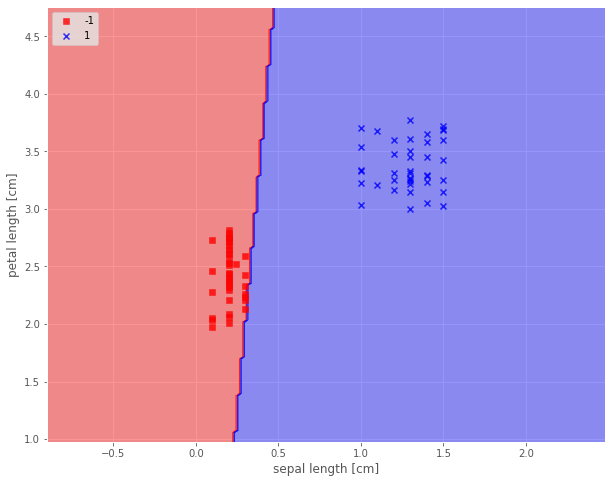

In [108]:

#https://www.bogotobogo.com/python/scikit-learn/Perceptron_Model_with_Iris_DataSet.php
from matplotlib.colors import ListedColormap
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:,  0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, claz in enumerate(np.unique(y)):
        plt.scatter(x=X[y==claz,0], y=X[y==claz,1],alpha=0.8, c=cmap(np.array(idx)),marker=markers[idx], label=claz)
    
plot_decision_regions(X, Y, classifier=pn)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.show()

## 6d. Support vector machine (SVM)
### Vladimir Vapnik invented Support Vector Machines in 1979 [19]. In its simplest, linear form, an
### SVM is a hyperplane that separates a set of positive examples from a set of negative examples
### with maximum margin. In the linear case, the margin is defined by the distance of
### the hyperplane to the nearest of the positive and negative examples. The formula for the output
### of a linear SVM is u = w*x + b where 'w' is the normal vector, 'x' is the input data vector, and b is a bias/threshold term. The separating hyperplane is the plane u=0. The nearest points lie on the planes u = ±1. The margin is m= 1/||w||
### Maximizing margin can be expressed via the following optimization problem: 
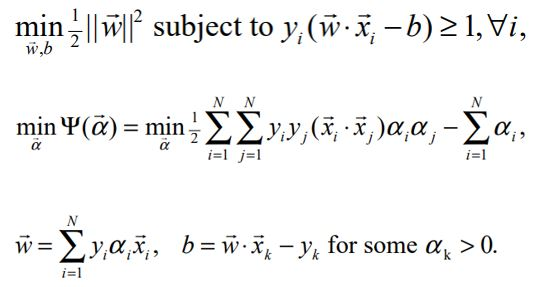

### For more details on theory, refer to the following references:
### https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf
### http://web.mit.edu/6.034/wwwbob/svm-notes-long-08.pdf
### JHU: Algorithm for data scientist - MachineLearningIII.pdf
### https://pythonprogramming.net/predictions-svm-machine-learning-tutorial/
### https://jeremykun.com/2017/06/05/formulating-the-support-vector-machine-optimization-problem/
### http://alex.smola.org/papers/2001/SchHerSmo01.pdf
### https://nlp.stanford.edu/IR-book/html/htmledition/support-vector-machines-the-linearly-separable-case-1.html
### http://cs229.stanford.edu/notes/cs229-notes3.pdf

In [101]:
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
style.use('ggplot')

class Support_Vector_Machine:
    def __init__(self, visualization=True):
        self.visualization = visualization
        self.colors = {1:'r',-1:'b'}
        if self.visualization:
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(1,1,1)
    
    # train
    def fit(self, data):
        self.data = data        
        opt_dict = {}
        transforms = [[1,1],[-1,1],[-1,-1],[1,-1]]                  

        """
        find the min and max feature values from the data
        This is not the min/max of each feature but the min/max of the whole data set
        """
        all_data = []
        for yi in self.data:
            for featureset in self.data[yi]:
                for feature in featureset:
                    all_data.append(feature)
        
        self.max_feature_value = max(all_data)
        self.min_feature_value = min(all_data)
        all_data = None
        
        #step_sizes = [self.max_feature_value*0.1, self.max_feature_value*0.01,self.max_feature_value*0.001,]
        step_sizes = [self.max_feature_value*0.1, self.max_feature_value*0.01,self.max_feature_value*0.001,]
        
        # extremely expensive
        b_range_multiple = 2
        b_multiple = 5
        latest_optimum = self.max_feature_value*15    
        
        for step in step_sizes:            
            w = np.array([latest_optimum,latest_optimum])
            optimized = False
            
            while not optimized:
                epochs = 1
                for b in np.arange(-1*(self.max_feature_value*b_range_multiple),
                                   self.max_feature_value*b_range_multiple, step*b_multiple):
                    
                    for transformation in transforms:
                        w_t = w*transformation
                        found_option = True
                        
                        """
                        Optmize the decission function of the SVM for each class label y_i in the data, 
                        and the data features(x_i) of i.
                        The decission function is optimized when:
                        1. xi•w+b ≥ +1 when yi =+1
                        2. xi•w+b ≤ –1 when yi =–1
                        3. The two conditions can be combined to yield; y_i*(np.dot(w_t,x_i)+b) >= 1
                        4. Clearly, the decission function is optmized when w and b are optimized
                        """
                        for claz in self.data:                            
                            for x_i in self.data[claz]: #feature_values = data point for i = class
                                y_i = claz
                                if not ((y_i*(np.dot(w_t,x_i)+b)) >= 1): #decission boundary function
                                    found_option = False
                            
                                    #print(x_i,':',y_i*(np.dot(w_t,x_i)+b))
                               # else:
                               #     found_option = False
                               #     w_t = w_t+0.0001 * np.dot(x_i, y_i) - (2 * 1/epochs * w_t)-b
                        
                        print('found_option= ', found_option)                                      
                        if found_option:
                            opt_dict[np.linalg.norm(w_t)] = [w_t,b]
                            #print('opt_dict = ', opt_dict)
                            
                if w[0] < 0:
                    optimized = True
                    #print('Optimized a step.')
                else:
                    w = w - step
                epochs = epochs+1
            norms = sorted([n for n in opt_dict])
            #print('norms =', norms)
            #||w|| : [w,b]
            opt_choice = opt_dict[norms[0]]
            self.w = opt_choice[0]
            self.b = opt_choice[1]
            latest_optimum = opt_choice[0][0]+step*2
            
        #for i in self.data:
        #    for xi in self.data[i]:
        #        yi=i
        #        print(xi,':',yi*(np.dot(self.w,xi)+self.b))            

    def predict(self,features):
        classification = np.sign(np.dot(np.array(features),self.w)+self.b)
        if (classification !=0 and self.visualization):
            self.ax.scatter(features[0], features[1], s=200, marker='*', c=self.colors[classification])
        #print('classification= ',classification)
        return classification

    def visualize(self):
        [[self.ax.scatter(x[0],x[1],s=100,color=self.colors[i]) for x in data_dict[i]] for i in data_dict]
        
        def hyperplane(x,w,b,v):
            return (-w[0]*x-b+v) / w[1]

        datarange = (self.min_feature_value*0.9,self.max_feature_value*1.1)
        hyp_x_min = datarange[0]
        hyp_x_max = datarange[1]

        # (w.x+b) = 1
        # positive support vector hyperplane
        psv1 = hyperplane(hyp_x_min, self.w, self.b, 1)
        psv2 = hyperplane(hyp_x_max, self.w, self.b, 1)
        self.ax.plot([hyp_x_min,hyp_x_max],[psv1,psv2], 'k')

        # (w.x+b) = -1
        # negative support vector hyperplane
        nsv1 = hyperplane(hyp_x_min, self.w, self.b, -1)
        nsv2 = hyperplane(hyp_x_max, self.w, self.b, -1)
        self.ax.plot([hyp_x_min,hyp_x_max],[nsv1,nsv2], 'k')

        # (w.x+b) = 0
        # positive support vector hyperplane
        db1 = hyperplane(hyp_x_min, self.w, self.b, 0)
        db2 = hyperplane(hyp_x_max, self.w, self.b, 0)
        self.ax.plot([hyp_x_min,hyp_x_max],[db1,db2], 'y--')

        plt.show()

found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
fo

found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  Fals

found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  Fals

found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False


found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  F

found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  

found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  True
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option= 

found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=

found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=

found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=

found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=

found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=

found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=

found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=  False
found_option=

NameError: name 'data' is not defined

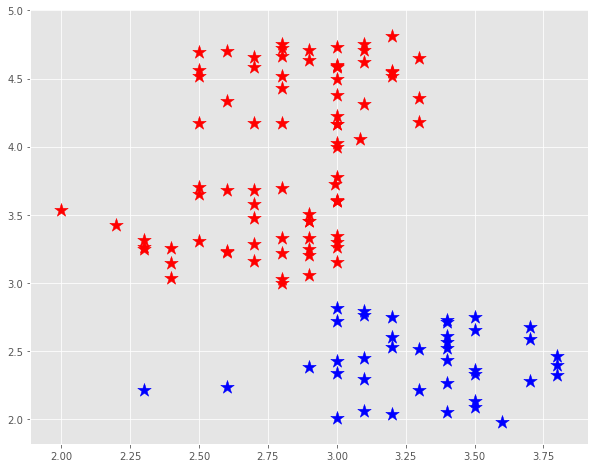

In [102]:
import pandas as pd
#Let's use the data after outliers are removed
df6d = pd.read_csv("C:/Users/maa5m/Desktop/2018_school/ENG685.621.81.FA19_Algorithms_for_Data_Science/" \
                 "MAtanga_Programming_HW2/outputs/iris_data_outlier_removed_final2.csv")

"""
Since support vector machine is more a two class classification algorithm, we would pair the classes for classification

"""
data6d = df6d[['sepal width', 'New Feature 2','class']]

setosa = data6d[data6d['class']==1]
setosa = setosa[['sepal width', 'New Feature 2']].values

versicolor = data6d[data6d['class']==2]
versicolor = versicolor[['sepal width', 'New Feature 2']].values

virginica = data6d[data6d['class']==3]
virginica = virginica[['sepal width', 'New Feature 2']].values

#data belong to setosa or versicolor
label_data1 = {-1: np.array(setosa), 1:np.array(versicolor)}
#print(label_data1)

#data belong to setosa or virginica
label_data2 = {-1: np.array(setosa), 1:np.array(virginica)}

#data belong to versicolor or virginca
label_data3 = {-1: np.array(versicolor), 1:np.array(virginica)}

pred1 = data6d.drop(['class'], axis=1)
pred1 = np.array(pred1.values)

svm = Support_Vector_Machine()
svm.fit(data=label_data1)

for p in pred1:
    svm.predict(p)
svm.visualize()


In [76]:
iris = pd.read_csv("C:/Users/maa5m/Desktop/2018_school/ENG685.621.81.FA19_Algorithms_for_Data_Science/" \
                 "MAtanga_Programming_HW2/outputs/iris_data_outlier_removed_final2.csv")
X = iris[:, 2:]  # we only take the last two features.
y = iris['class']
C = 1.0  # SVM regularization parameter


# SVC with linear kernel
svc = svm.SVC(kernel='linear', C=C).fit(X, y)
# LinearSVC (linear kernel)
lin_svc = svm.LinearSVC(C=C).fit(X, y)
# SVC with RBF kernel
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
# SVC with polynomial (degree 3) kernel
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)


h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# title for the plots
titles = ['SVC with linear kernel', 'LinearSVC (linear kernel)', 'SVC with RBF kernel', 'SVC with polynomial (degree 3) kernel']
 
for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
 
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
 
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
 
    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('Petal length')
    plt.ylabel('Petal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])
plt.show()

TypeError: '(slice(None, None, None), slice(2, None, None))' is an invalid key